# Fracture Detection using the FractAtlas Dataset and Pytorch


This notebook uses the FracAtlas dataset, PyTorch, and three different pretrained models (Resnet50, VGG16, and DenseNet) to determine whether or not there is a bone fracture present in XRays. The images are rearranged in the /kaggle/working directory into train/test sets given a 95/5 ratio. The notebook uses a GPU T4 x2 accelerator to boost performance.

Kaggle Hosted Notebook: [![Kaggle](https://img.shields.io/badge/Kaggle-035a7d?style=for-the-badge&logo=kaggle&logoColor=white)](https://www.kaggle.com/code/edyvision/fracture-detection-with-pytorch-fracatlas)

In [1]:
import os
import io
import json
import numpy as np
import pandas as pd
import shutil
import random
import torch
import torchvision
import h5py
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

root_dir = '/kaggle/input/fracatlas'
write_dir = '/kaggle/working/'
train_dir = '/kaggle/input/fracatlas/train'
test_dir = '/kaggle/input/fracatlas/test'
validation_dir = '/kaggle/input/fracatlas/val'
non_fractured_dir = '/kaggle/input/fracatlas/not fractured'

# Load data paths
train_image_filepaths = [
    x for x in os.listdir(f"{train_dir}/img")
]
train_annotation_filepaths = [f"{train_dir}/ann/{x}" for x in os.listdir(f"{train_dir}/ann")]

test_image_filepaths = [x for x in os.listdir(f"{test_dir}/img")]
test_annotation_filepaths = [f"{test_dir}/ann/{x}" for x in os.listdir(f"{test_dir}/ann")]

print(f"Loaded {len(train_image_filepaths)} image files for training")
print(f"Loaded {len(test_image_filepaths)} image files for testing")

Using PyTorch version 2.1.2
Loaded 574 image files for training
Loaded 61 image files for testing


In [2]:
class_names = ["not fractured", "fractured"]
print(f"The two classnames observed are '{class_names[0]}' and '{class_names[0]}'")

The two classnames observed are 'not fractured' and 'not fractured'


Everything in the train are fractured, there is a separate folder of non-fractured. The test folder is also all fractured. We'll combine the test/train into one set called fractured and the not-fractured into another. We'll then do an 90/10 split for the model(s).

In [3]:
train_image_filepaths.extend(test_image_filepaths)
fractured_image_filepaths = train_image_filepaths
fractured_annotation_filepaths = train_annotation_filepaths.extend(test_annotation_filepaths)

nonfractured_image_filepaths = [
    x for x in os.listdir(f"{non_fractured_dir}/img")
]
nonfractured_annotation_filepaths = [x for x in os.listdir(f"{non_fractured_dir}/ann")]

print(f"Loaded {len(fractured_image_filepaths)} image files of fractured bones")
print(f"Loaded {len(nonfractured_image_filepaths)} image files of non-fractured bones")

Loaded 635 image files of fractured bones
Loaded 3366 image files of non-fractured bones


In [4]:
# Write the class folders and the test folder with the respective classes within
os.mkdir(os.path.join(write_dir, 'test'))

# write the folders with class names in test dir
for c in class_names:
    os.mkdir(os.path.join(write_dir, 'test', c))

# Copy all non-fractured images
shutil.copytree(
    os.path.join(non_fractured_dir, 'img'), os.path.join(write_dir, "not fractured"), dirs_exist_ok=True
)

# Copy all fractured images - will need dirs_exist_ok set to True due to loop
for i, src_dir in enumerate([test_dir, train_dir]):
    shutil.copytree(
        os.path.join(src_dir, 'img'), os.path.join(write_dir, "fractured"), dirs_exist_ok=True
    )


In [5]:
# Split each set per the 95/5 ratio per class

for c in class_names:
    images = [x for x in os.listdir(os.path.join(write_dir, c))]
    selected_images = random.sample(images, int(.05*len(images)))
    
    for image in selected_images:
        source_path = os.path.join(write_dir, c, image)
        target_path = os.path.join(write_dir, 'test', c, image)
        shutil.move(source_path, target_path)

## Create Custom Dataset

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
class BoneXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, class_names, transform):
        self.images = {}
        self.transform = transform
        self.labels = []
        self.class_names = class_names
        self.image_dirs = image_paths
        
        def get_images(class_name):
            images = [
                x for x in os.listdir(image_paths[class_name])
            ]
            print(f'Found {len(images)} {class_name} examples')
            
            return images
        
        for c in self.class_names:
            self.images[c] = get_images(c)
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') # 3 channels for resnet18
        
        return self.transform(image), self.class_names.index(class_name)

## Prepare Transformers

In [8]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [9]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

## Prepare DataLoaders

In [10]:
train_dirs = {
    'not fractured': f'{write_dir}not fractured',
    'fractured': f'{write_dir}fractured'
}
print(train_dirs)
train_dataset = BoneXRayDataset(
    train_dirs, class_names, train_transform
)

{'not fractured': '/kaggle/working/not fractured', 'fractured': '/kaggle/working/fractured'}
Found 3198 not fractured examples
Found 604 fractured examples


In [11]:
test_dirs = {
    'not fractured': f'{write_dir}/test/not fractured',
    'fractured': f'{write_dir}/test/fractured'
}
print(test_dirs)
test_dataset = BoneXRayDataset(
    test_dirs, class_names, test_transform
)

{'not fractured': '/kaggle/working//test/not fractured', 'fractured': '/kaggle/working//test/fractured'}
Found 168 not fractured examples
Found 31 fractured examples


In [12]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dl_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 634
Num of test batches 34


## Data Visualization

In [13]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1,6, i + 1, xticks=[], yticks=[])
        
        image = image.numpy().transpose((1,2, 0)) # To adhere to matplotlib needs
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color=col)
        
    plt.tight_layout()
    plt.show()

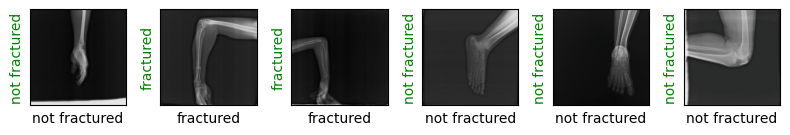

In [14]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

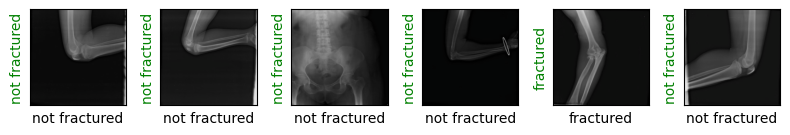

In [15]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

The following image has the following dimensions: (224, 224, 3)



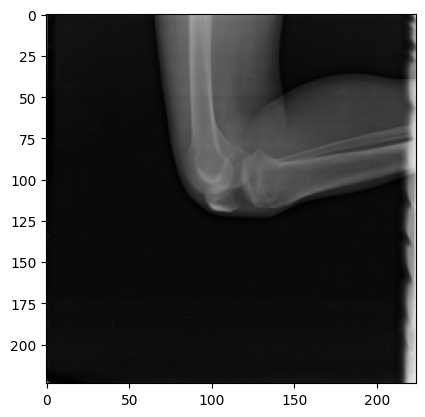

In [16]:
# Grab an image and figure out shape
image = images[0].numpy().transpose((1, 2, 0)) # To adhere to matplotlib needs
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
        
image = image * std + mean
image = np.clip(image, 0., 1.)
plt.imshow(image)

print(f"The following image has the following dimensions: {image.shape}\n")


## Creating the Models

In [17]:
# Set to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Setup Resnet50 Model
resnet = torchvision.models.resnet50(pretrained=True)
num_filters = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_filters, 1) # set up for binary classification
reset = resnet.to(device)
print(resnet) # print model structure

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# Setup VGG16 Model
vgg16 = torchvision.models.vgg16(pretrained=True)
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_ftrs, 1) # set up for binary classification
vgg16 = vgg16.to(device)

print(vgg16) # print model structure

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# Setup DenseNet Model
dense_net = torchvision.models.densenet121(pretrained=True)
num_ftrs = dense_net.classifier.in_features
dense_net.classifier = torch.nn.Linear(num_ftrs, 1)  # set up for binary classification
dense_net = dense_net.to(device)

print(dense_net) # print model structure

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 83.9MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
def show_preds(model):
    model.eval()
    images, labels = next(iter(dl_test))
    outputs = model(images.to(device))
    _, preds = torch.max(outputs.to(device), 1)
    show_images(images, labels, preds)

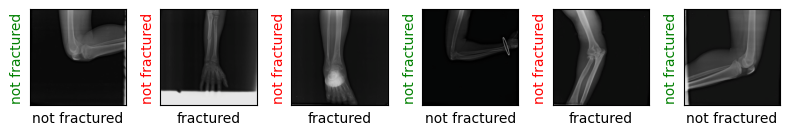

In [22]:
show_preds(resnet)

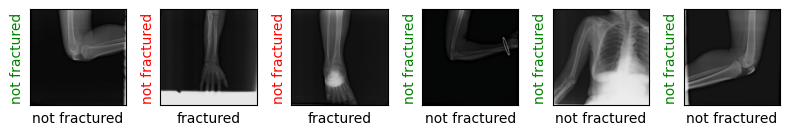

In [23]:
show_preds(vgg16)

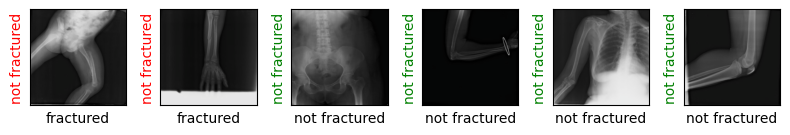

In [24]:
show_preds(dense_net)

## Train and Evaluaton All Models

In [32]:
# Train Model
def train_model(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for train_step, (inputs, targets) in enumerate(dataloader):
        outputs = model(inputs.to(device))
        targets = targets.view(-1, 1).float()
        
        loss = criterion(outputs.to(device), targets.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.sigmoid(outputs.to(device))
        preds = (preds > 0.5).float()
        
        correct += (preds == targets.to(device)).sum().item()
        total += targets.size(0)
        
        if train_step % 20 == 0:
            print('#', sep=' ', end='', flush=True)
    
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    
    print(f'\n\nTraining Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    return epoch_loss, epoch_accuracy

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for eval_step, (inputs, targets) in enumerate(dataloader):
            outputs = model(inputs.to(device))
            targets = targets.view(-1, 1).float()  # Ensure targets are of shape [batch_size, 1]
            
            loss = criterion(outputs.to(device), targets.to(device))
            running_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            correct += (preds.to(device) == targets.to(device)).sum().item()
            total += targets.size(0)
            
            all_labels.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            if eval_step % 20 == 0:
                print(f'Validation Loss: {(running_loss / total):.4f}, Accuracy: {(correct / total):.4f}')

                show_preds(model)
    
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    
    print(f'\n\nValidation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    return epoch_loss, epoch_accuracy ,accuracy, precision, recall, f1, roc_auc


# Run Model (Train/Evaluation Loop)
def run_model(model, dl_train, dl_test, model_name: str, best_accuracy: float):
    criterion = torch.nn.BCEWithLogitsLoss()
    total_epochs = 0
    
    # Learning Rate
    learning_rate = 3e-5

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    while(True):
        print(f"\nCurrent Epoch: {total_epochs+1}")

        # TRAIN MODEL
        print("Training Model...")
        train_loss, train_accuracy = train_model(model, dl_train, criterion, optimizer)
        print("Model Training Complete")

        # EVALUATE MODEL
        print("Validating Model...")
        val_loss, val_accuracy, accuracy, precision, recall, f1, roc_auc = evaluate_model(
            model, dl_test, criterion
        )
        
        print("Model Validation Complete")

        print(f"\nEpoch {total_epochs+1} Summary")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        total_epochs += 1 # increment epochs

        # Save the best model
        if val_accuracy > best_accuracy:
            print(f'\n{model_name.upper()} Model performance condition met')
            
            best_accuracy = val_accuracy
            
            print(
                f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}"
            )
            print(
                f"F1 Score: {f1:.4f}, AUC-ROC: {roc_auc:.4f}"
            )
            break


    # Save the one with the best performance
    torch.save(model.state_dict(), f'{model_name}.hd5')
        


Current Epoch: 1
Training Model...
################################

Training Validation Loss: 0.1950, Accuracy: 0.9266
Model Training Complete
Validating Model...
Validation Loss: 0.3224, Accuracy: 0.8333


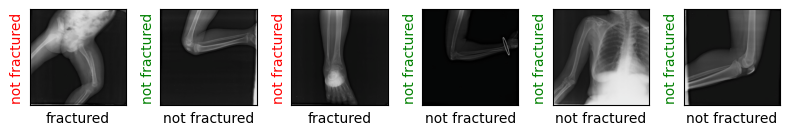

Validation Loss: 0.2672, Accuracy: 0.8889


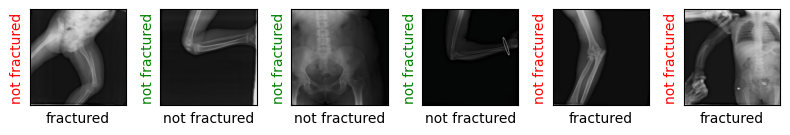



Validation Loss: 0.3160, Accuracy: 0.8794
Model Validation Complete

Epoch 1 Summary
Train Loss: 0.1950, Train Accuracy: 0.9266
Val Loss: 0.3160, Val Accuracy: 0.8794

RESNET50 Model performance condition met
Accuracy: 0.8794, Precision: 0.9398, Recall: 0.8041
F1 Score: 0.8667, AUC-ROC: 0.8776


In [33]:
# Run Resnet50 Training and Evaluation
run_model(resnet, dl_train, dl_test, "resnet50", .85)


Current Epoch: 1
Training Model...
################################

Training Validation Loss: 0.2380, Accuracy: 0.9035
Model Training Complete
Validating Model...
Validation Loss: 0.4013, Accuracy: 0.6667


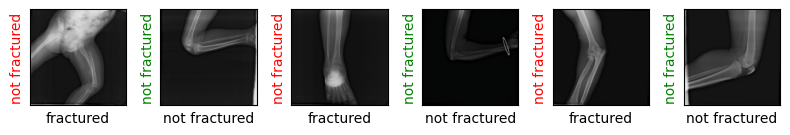

Validation Loss: 0.3105, Accuracy: 0.8413


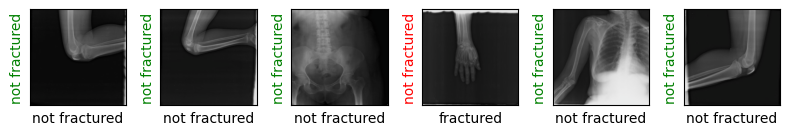



Validation Loss: 0.3011, Accuracy: 0.8593
Model Validation Complete

Epoch 1 Summary
Train Loss: 0.2380, Train Accuracy: 0.9035
Val Loss: 0.3011, Val Accuracy: 0.8593

VGG16 Model performance condition met
Accuracy: 0.8593, Precision: 0.8016, Recall: 0.9712
F1 Score: 0.8783, AUC-ROC: 0.8540


In [34]:
# Run VGG16 Training and Evaluation
run_model(vgg16, dl_train, dl_test, "vgg16", .85)


Current Epoch: 1
Training Model...
################################

Training Validation Loss: 0.4788, Accuracy: 0.7735
Model Training Complete
Validating Model...
Validation Loss: 0.6824, Accuracy: 0.5000


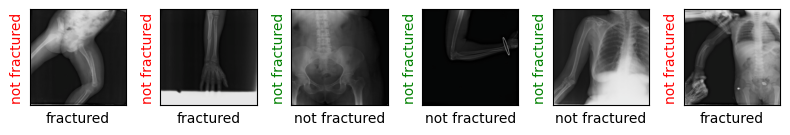

Validation Loss: 0.3823, Accuracy: 0.8175


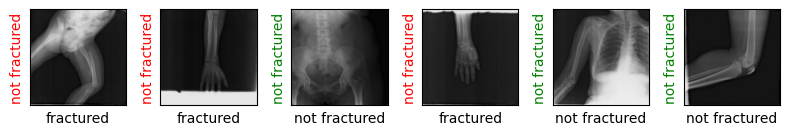



Validation Loss: 0.4183, Accuracy: 0.7889
Model Validation Complete

Epoch 1 Summary
Train Loss: 0.4788, Train Accuracy: 0.7735
Val Loss: 0.4183, Val Accuracy: 0.7889

Current Epoch: 2
Training Model...
################################

Training Validation Loss: 0.3468, Accuracy: 0.8532
Model Training Complete
Validating Model...
Validation Loss: 0.3232, Accuracy: 0.8333


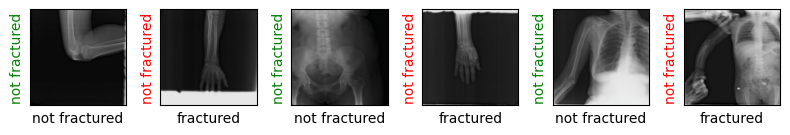

Validation Loss: 0.2995, Accuracy: 0.8095


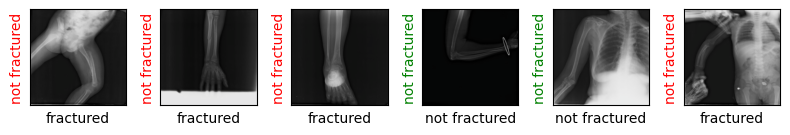



Validation Loss: 0.2960, Accuracy: 0.8141
Model Validation Complete

Epoch 2 Summary
Train Loss: 0.3468, Train Accuracy: 0.8532
Val Loss: 0.2960, Val Accuracy: 0.8141

Current Epoch: 3
Training Model...
################################

Training Validation Loss: 0.2627, Accuracy: 0.8961
Model Training Complete
Validating Model...
Validation Loss: 0.0716, Accuracy: 1.0000


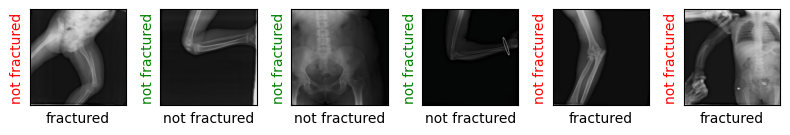

Validation Loss: 0.2282, Accuracy: 0.8968


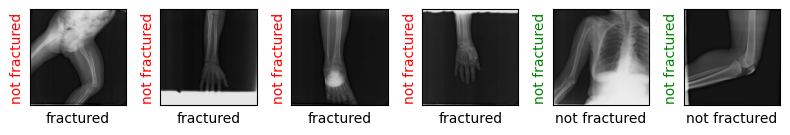



Validation Loss: 0.2560, Accuracy: 0.8894
Model Validation Complete

Epoch 3 Summary
Train Loss: 0.2627, Train Accuracy: 0.8961
Val Loss: 0.2560, Val Accuracy: 0.8894

DENSE_NET Model performance condition met
Accuracy: 0.8894, Precision: 0.8969, Recall: 0.8788
F1 Score: 0.8878, AUC-ROC: 0.8894


In [35]:
# Run DenseNet Training and Evaluation
run_model(dense_net, dl_train, dl_test, "dense_net", .85)